# Modelo de Clasificación para Predicción de Segmento RFM (Nike Colombia)

En el notebook **“1. Modelo de clusterización RFM.ipynb”** se construyó la segmentación de clientes a partir del modelo K-means utilizando las variables **Recency, Frequency y Monetary discretizadas (RFM scores)**. Dicho modelo fue seleccionado por su coherencia con el comportamiento transaccional y su capacidad para identificar 7 segmentos accionables.

En este notebook se desarrolla el **modelo de clasificación**, cuyo objetivo es predecir el segmento RFM al que pertenecerá un **nuevo cliente**, utilizando únicamente la información disponible en su **primera compra**.

---

## Variables utilizadas para predecir el segmento

A partir del análisis exploratorio (EDA), se identificaron cuatro variables categóricas con suficiente señal explicativa:

- **BU_first** (unidad de negocio del primer producto comprado)  
- **Categoria_first** (categoría deportiva del producto inicial)  
- **first_disc_group** (tipo de descuento aplicado en la primera compra)  
- **Genero_first** (línea de género del producto)  

Además, se incluye la variable numérica:

- **first_ticket** (valor pagado en la primera compra)

Estas variables se transforman mediante **One-Hot Encoding** para preparar la matriz de entrenamiento. Se descartaron variables como **City_first** y **Familia/Silueta_first**, ya que su alta cardinalidad generaba un número excesivo de columnas dummy, aumentando complejidad y ruido sin mejorar el rendimiento del modelo.

---

## Modelos de clasificación evaluados

Se entrenan y comparan tres algoritmos supervisados:

1. **Árbol de decisión**  
2. **Red neuronal (MLP)**  
3. **XGBoost**

El desempeño se evalúa principalmente mediante **accuracy** y **F1-macro**, una métrica adecuada debido al desbalance natural entre segmentos.

---

## Incorporación de Conformal Prediction

Una vez seleccionado el mejor modelo, se aplicará **Conformal Prediction** para obtener niveles de confianza y predicciones por conjunto. Esta técnica permite identificar casos ambiguos, evitar clasificaciones poco seguras y aportar mayor confiabilidad al sistema de segmentación anticipada aplicada al negocio.

La incorporación de Conformal Prediction cobra especial relevancia en este caso, ya que el objetivo es predecir el **segmento RFM a partir únicamente de la primera compra de un cliente**. Dado que los segmentos RFM dependen de variables que evolucionan con el tiempo (como recency y frequency), es natural que el modelo de clasificación tienda a asignar inicialmente categorías específicas asociadas a perfiles de entrada, como “nuevos/ticket alto” o “nuevos/ticket bajo”. Sin embargo, estas categorías no necesariamente reflejan la evolución futura del cliente.

**Mediante Conformal Prediction es posible obtener un conjunto de posibles segmentos en lugar de una única predicción puntual.** Esto permite capturar la incertidumbre inherente al proceso y reconocer, por ejemplo, que aunque el modelo base clasifique a un cliente como “nuevo/ticket alto”, su intervalo de confianza también puede incluir segmentos como “champion” o “leales recientes”, lo cual representa **rutas potenciales de evolución según su comportamiento futuro.** Esta capa adicional de interpretación mejora la capacidad del negocio para tomar decisiones más informadas y gestionar acciones tempranas sobre clientes con alto potencial.


In [148]:
# ======================================
# 1. Importación de librerías
# ======================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")

# ======================================
# 2. Lectura de la base enriquecida (clusters + RFM)
# ======================================

# Nombre del archivo principal de datos
fname = "orders_enriched_with_RFM_KMdisc.csv"

# Ruta local (si el archivo está en la carpeta 'data/' del repo clonado)
local_path = os.path.join("data", fname)

# URL al archivo en GitHub (repositorio público)
raw_url = (
    "https://raw.githubusercontent.com/"
    "daviid24/Proyecto-Maestria-MIIA/main/data/"
    + fname
)

# Si el archivo existe localmente, se lee desde el disco
# En caso contrario, se descarga directamente desde GitHub
if os.path.exists(local_path):
    df = pd.read_csv(local_path, encoding="utf-8-sig")
else:
    df = pd.read_csv(raw_url, encoding="utf-8-sig")

# Vista previa de la base cargada
df.head()

,FechaSinHora,Order,Client_Document,UF,City,RealDiscount,Discounts_Names,Shipping_Status,Model,BU,...,R_cont,F_cont,M_cont,R_score,F_score,M_score,RFM_code,avg_ticket,KMdisc_k7,cluster_name
0,2024-02-06,1408880501419-01,1010121222,Antioquia,Medellín,Base inline,Flete Gratis,No Shipping Payment,BV2772-010,Apparel Division,...,625,2,911555,1,2,5,R1F2M5,455777.500,4,En riesgo (alto valor)
1,2024-02-06,1408840501369-01,80122644,"Bogotá, D.C.","Bogotá, D.c.",Base inline,Flete Gratis,No Shipping Payment,CN8490-002,Footwear Division,...,77,3,1912885,5,3,5,R5F3M5,637628.333,5,Leales recientes
2,2024-02-06,1408830501357-01,1047499286,Bolívar,Cartagena De Indias,Base inline,Flete Gratis,No Shipping Payment,CU8890-651,Apparel Division,...,628,2,877941,1,2,5,R1F2M5,438970.500,4,En riesgo (alto valor)
3,2024-02-06,1408860501387-01,80096408,Cundinamarca,Cajicá,Base inline,NaN,Shipping Payment,CV2545-100,Apparel Division,...,633,1,210042,1,1,1,R1F1M1,210042.000,3,Dormidos bajo valor
4,2024-02-06,1408810501345-01,91018601,Santander,Barbosa,Base inline,Flete Gratis,No Shipping Payment,DC7695-003,Footwear Division,...,633,1,789832,1,1,4,R1F1M4,789832.000,0,Ocasionales antiguos


In [171]:
# ======================================
# Base de modelado (nivel cliente)
#    Variables: BU_first, Categoria_first, first_disc_group
# ======================================

import pandas as pd
import numpy as np

# Columnas clave
CLIENT_ID          = "Client_Document"
DATE_COL           = "FechaSinHora"
BU_COL             = "BU"
CAT_COL            = "Categoría"
DISCOUNT_NAME_COL  = "Discounts_Names"
GENERO_COL         = "Género"
PAID_COL           = "Valor_Pagado"


# Detectar columna de cluster discreto (k-means)
cluster_col = [c for c in df.columns if c.startswith("KMdisc_k")]
assert len(cluster_col) == 1, "No se encontró la columna de cluster KMdisc_k*."
cluster_col = cluster_col[0]

df = df.copy()
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df[CLIENT_ID] = df[CLIENT_ID].astype(str)

In [150]:
# --------------------------
# Clasificar Discounts_Names
# --------------------------
def clasificar_descuento(nombre):
    if pd.isna(nombre) or str(nombre).strip() == "":
        return "Sin descuento"
    s = str(nombre).lower()

    if "emplead" in s:
        return "Especial empleados"
    if "flete gratis" in s and ("%" not in s):
        return "Solo envío gratis"
    if any(p in s for p in ["10%", "15%", "20%"]):
        return "Descuento bajo (≤20%)"
    if any(p in s for p in ["25%", "30%", "35%"]):
        return "Descuento medio (21–35%)"
    if any(p in s for p in ["40%", "45%", "50%"]):
        return "Descuento alto (≥36%)"
    return "Otros"

df["disc_group_line"] = df[DISCOUNT_NAME_COL].apply(clasificar_descuento)
df["disc_group_line"].value_counts()

disc_group_line
Solo envío gratis           36062
Descuento medio (21–35%)    12548
Descuento bajo (≤20%)       11922
Descuento alto (≥36%)        8649
Sin descuento                7750
Otros                         608
Name: count, dtype: int64

In [172]:
# --------------------------
# Primera compra por cliente (categóricas + cluster)
# --------------------------
df_sorted = df.sort_values([CLIENT_ID, DATE_COL])

first_purchase = (
    df_sorted
    .groupby(CLIENT_ID, as_index=False)
    .first()
    [[CLIENT_ID, BU_COL, CAT_COL, "disc_group_line",GENERO_COL, PAID_COL, cluster_col, "cluster_name"]]
    .rename(columns={
        BU_COL: "BU_first",
        CAT_COL: "Categoria_first",
        "disc_group_line": "first_disc_group",
        "Género": "Genero_first",
        PAID_COL: "first_ticket",
        cluster_col: "cluster_id"
    })
)
first_purchase.head()

,Client_Document,BU_first,Categoria_first,first_disc_group,Genero_first,first_ticket,cluster_id,cluster_name
0,***02,Footwear Division,NIKE SPORTSWEAR,Descuento medio (21–35%),HOMBRE (MENS),479382,2,Champions
1,***03,Footwear Division,JORDAN BRAND,Solo envío gratis,JORDAN BRAND,579790,1,Nuevos / ticket alto
2,***07,Footwear Division,NIKE SPORTSWEAR,Descuento bajo (≤20%),HOMBRE (MENS),615092,5,Leales recientes
3,***08,Footwear Division,JORDAN BRAND,Solo envío gratis,JORDAN BRAND,785672,0,Ocasionales antiguos
4,***10,Footwear Division,RUNNING,Solo envío gratis,HOMBRE (MENS),373908,6,Nuevos / ticket bajo


In [173]:
# --------------------------
# Unir todo
# --------------------------

rfm_cont = (
    df.groupby(CLIENT_ID, as_index=False)
      .first()[[CLIENT_ID, "R_cont", "F_cont", "M_cont"]]
)
client_model = first_purchase.merge(rfm_cont, on=CLIENT_ID, how="left")

# Tipos
client_model["cluster_id"] = client_model["cluster_id"].astype(int)
for c in ["BU_first", "Categoria_first", "first_disc_group","Genero_first"]:
    client_model[c] = client_model[c].astype("category")

print("Dimensiones de client_model:", client_model.shape)
client_model.head()

Dimensiones de client_model: (43663, 11)


,Client_Document,BU_first,Categoria_first,first_disc_group,Genero_first,first_ticket,cluster_id,cluster_name,R_cont,F_cont,M_cont
0,***02,Footwear Division,NIKE SPORTSWEAR,Descuento medio (21–35%),HOMBRE (MENS),479382,2,Champions,4,4,1403585
1,***03,Footwear Division,JORDAN BRAND,Solo envío gratis,JORDAN BRAND,579790,1,Nuevos / ticket alto,140,1,579790
2,***07,Footwear Division,NIKE SPORTSWEAR,Descuento bajo (≤20%),HOMBRE (MENS),615092,5,Leales recientes,164,2,816731
3,***08,Footwear Division,JORDAN BRAND,Solo envío gratis,JORDAN BRAND,785672,0,Ocasionales antiguos,349,1,785672
4,***10,Footwear Division,RUNNING,Solo envío gratis,HOMBRE (MENS),373908,6,Nuevos / ticket bajo,155,1,373908


### Train/test split

In [174]:
# ======================================
# Features (X) y target (y)
# ======================================

# Features seleccionadas
cat_features = ["BU_first", "Categoria_first", "first_disc_group","Genero_first"]
num_features = ["first_ticket"]
target_col   = "cluster_id"

# One-hot encoding de categóricas
X_cat = pd.get_dummies(
    client_model[cat_features],
    drop_first=False,
    prefix=cat_features
)

# Numéricas continuas
X_num = client_model[num_features].copy()

# Matriz final de features
X = pd.concat([X_num, X_cat], axis=1)
y = client_model[target_col].copy()

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("\nPrimeras columnas de X:")
X.iloc[:5, :10]


Shape X: (43663, 31)
Shape y: (43663,)

Primeras columnas de X:


,first_ticket,BU_first_Apparel Division,BU_first_Equipment Division,BU_first_Footwear Division,BU_first_Otro,Categoria_first_ACTION SPORTS,Categoria_first_ATHLETIC TRAINING,Categoria_first_BASKETBALL,Categoria_first_FOOTBALL/SOCCER,Categoria_first_FOOTBALL/SOCCER AN
0,479382,False,False,True,False,False,False,False,False,False
1,579790,False,False,True,False,False,False,False,False,False
2,615092,False,False,True,False,False,False,False,False,False
3,785672,False,False,True,False,False,False,False,False,False
4,373908,False,False,True,False,False,False,False,False,False


In [175]:
# ======================================
# Train/Test Split (estratificado por cluster)
# ======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Tamaños:")
print(" - X_train:", X_train.shape)
print(" - X_test : ", X_test.shape)

print("\nDistribución y_train:")
print(y_train.value_counts(normalize=True).sort_index().round(3))

print("\nDistribución y_test:")
print(y_test.value_counts(normalize=True).sort_index().round(3))


Tamaños:
 - X_train: (30564, 31)
 - X_test :  (13099, 31)

Distribución y_train:
cluster_id
0   0.186
1   0.229
2   0.026
3   0.172
4   0.072
5   0.085
6   0.228
Name: proportion, dtype: float64

Distribución y_test:
cluster_id
0   0.186
1   0.229
2   0.026
3   0.172
4   0.072
5   0.085
6   0.228
Name: proportion, dtype: float64


# Modelo 1: Arbol de decisión

In [180]:
# ======================================
# Librerías requeridas
# ======================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [176]:
# ======================================
# Árbol de Decisión
# ======================================
dt_clf = DecisionTreeClassifier(
    max_depth=6,          
    min_samples_leaf=200, # subir hojas mínimas para evitar sobreajuste
    random_state=42,
    class_weight="balanced"
)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=200, random_state=42)

In [177]:
# ======================================
# Evaluación del Árbol de Decisión
# ======================================

# Predicciones en test
y_pred = dt_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy  : {acc:.3f}")
print(f"F1 macro : {f1_macro:.3f}\n")

print("Reporte de clasificación por cluster:")
print(classification_report(y_test, y_pred, digits=3))


Accuracy  : 0.426
F1 macro : 0.290

Reporte de clasificación por cluster:
              precision    recall  f1-score   support

           0      0.401     0.543     0.461      2438
           1      0.472     0.428     0.449      3004
           2      0.090     0.125     0.105       345
           3      0.385     0.783     0.516      2259
           4      0.146     0.015     0.027       949
           5      0.000     0.000     0.000      1115
           6      0.604     0.385     0.470      2989

    accuracy                          0.426     13099
   macro avg      0.300     0.325     0.290     13099
weighted avg      0.400     0.426     0.390     13099



/Users/josemedina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josemedina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josemedina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


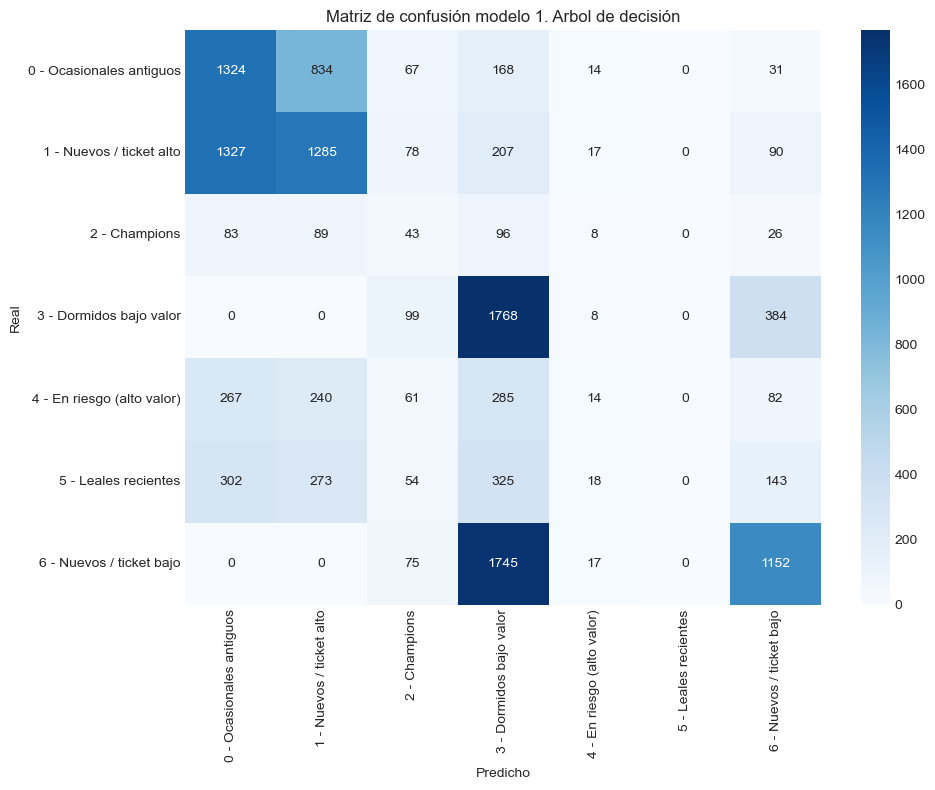

In [187]:
# ======================================
# Matriz de confusión
# ======================================

# Nombres de los clusters
client_model["cluster_id"] = client_model["cluster_id"].astype(int)
client_model["cluster_name"] = client_model["cluster_name"].astype(str)

id_to_name = (
    client_model[["cluster_id", "cluster_name"]]
    .drop_duplicates()
    .sort_values("cluster_id")
    .set_index("cluster_id")["cluster_name"]
    .to_dict()
)

cluster_ids = sorted(id_to_name.keys())
labels_txt = [f"{cid} - {id_to_name[cid]}" for cid in cluster_ids]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=cluster_ids)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión modelo 1. Arbol de decisión")
plt.tight_layout()
plt.show()

Top 15 variables más importantes:


,feature,importance
0,first_ticket,0.805
9,Categoria_first_FOOTBALL/SOCCER AN,0.075
24,first_disc_group_Solo envío gratis,0.040
28,Genero_first_NIÑOS (KIDS),0.020
19,first_disc_group_Descuento alto (≥36%),0.018
1,BU_first_Apparel Division,0.017
13,Categoria_first_NIKE SPORTSWEAR,0.012
23,first_disc_group_Sin descuento,0.006
8,Categoria_first_FOOTBALL/SOCCER,0.004
6,Categoria_first_ATHLETIC TRAINING,0.003


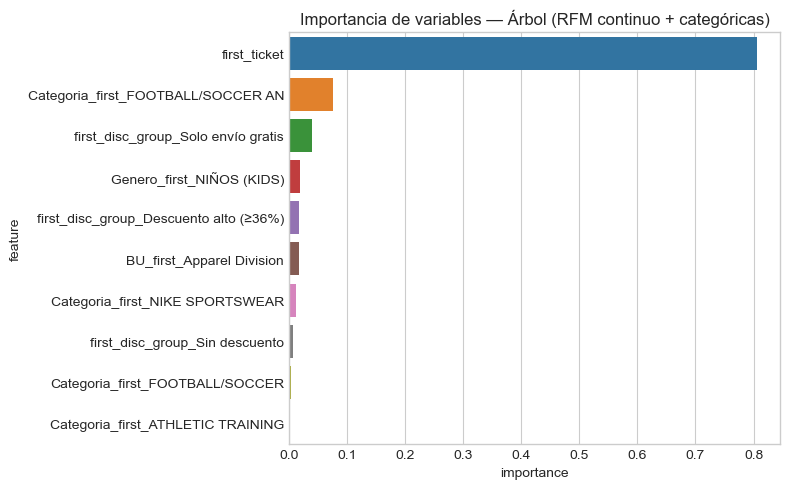

In [179]:
# ======================================
# 7. Importancia de variables
# ======================================

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": dt_clf.feature_importances_
}).sort_values("importance", ascending=False)

fi = fi[fi["importance"] > 0]

print("Top 15 variables más importantes:")
display(fi.head(15))

plt.figure(figsize=(8,5))
sns.barplot(
    data=fi.head(15),
    x="importance",
    y="feature"
)
plt.title("Importancia de variables — Árbol (RFM continuo + categóricas)")
plt.tight_layout()
plt.show()

# Modelo 2: Redes neuronales

In [181]:
# ======================================
# Librerías requeridas
# ======================================

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [182]:
# ======================================
# Escalado de features para red neuronal
# ======================================

scaler_nn = StandardScaler()

# Ajustamos el scaler solo con train y lo aplicamos a train y test
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn  = scaler_nn.transform(X_test)

print("Shapes escalados:")
print("X_train_nn:", X_train_nn.shape)
print("X_test_nn :", X_test_nn.shape)


Shapes escalados:
X_train_nn: (30564, 31)
X_test_nn : (13099, 31)


In [183]:
# ======================================
# Modelo: Red Neuronal (MLPClassifier)
# ======================================

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # dos capas ocultas: 64 y 32 neuronas
    activation="relu",
    solver="adam",
    alpha=1e-4,          # regularización L2
    batch_size="auto",
    learning_rate="adaptive",
    max_iter=200,
    random_state=42,
    early_stopping=True,  # usa parte del train como validación interna
    n_iter_no_change=10,
    verbose=False
)

mlp_clf.fit(X_train_nn, y_train)

print("Red neuronal entrenada")
print("N_iter (épocas realmente usadas):", mlp_clf.n_iter_)

Red neuronal entrenada
N_iter (épocas realmente usadas): 32


In [184]:
# ======================================
# Evaluación de la Red Neuronal
# ======================================

# Predicciones
y_pred_mlp = mlp_clf.predict(X_test_nn)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp  = f1_score(y_test, y_pred_mlp, average="macro")

print(f"Accuracy  (MLP): {acc_mlp:.3f}")
print(f"F1 macro (MLP): {f1_mlp:.3f}\n")

print("Reporte de clasificación — Red Neuronal:")
print(classification_report(y_test, y_pred_mlp, digits=3))


Accuracy  (MLP): 0.478
F1 macro (MLP): 0.292

Reporte de clasificación — Red Neuronal:
              precision    recall  f1-score   support

           0      0.418     0.444     0.431      2438
           1      0.484     0.580     0.528      3004
           2      0.000     0.000     0.000       345
           3      0.453     0.445     0.449      2259
           4      0.000     0.000     0.000       949
           5      0.375     0.003     0.005      1115
           6      0.518     0.810     0.632      2989

    accuracy                          0.478     13099
   macro avg      0.321     0.326     0.292     13099
weighted avg      0.417     0.478     0.423     13099



/Users/josemedina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josemedina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josemedina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


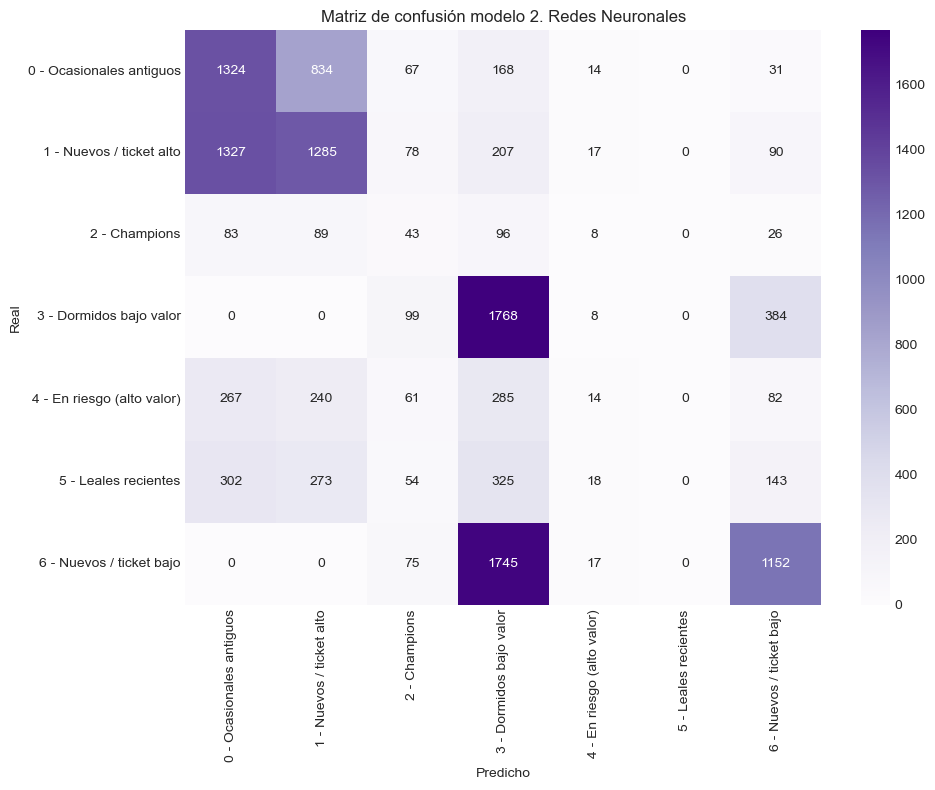

In [188]:
# ======================================
# Matriz de confusión
# ======================================

# Nombres de los clusters
client_model["cluster_id"] = client_model["cluster_id"].astype(int)
client_model["cluster_name"] = client_model["cluster_name"].astype(str)

id_to_name = (
    client_model[["cluster_id", "cluster_name"]]
    .drop_duplicates()
    .sort_values("cluster_id")
    .set_index("cluster_id")["cluster_name"]
    .to_dict()
)

cluster_ids = sorted(id_to_name.keys())
labels_txt = [f"{cid} - {id_to_name[cid]}" for cid in cluster_ids]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_mlp, labels=cluster_ids)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Purples"
)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión modelo 2. Redes Neuronales")
plt.tight_layout()
plt.show()

# Modelo 3: XGBoost

In [189]:
# ======================================
# Librerías requeridas
# ======================================
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [190]:
# ======================================
# Modelo: XGBoost (XGBClassifier)
# ======================================
num_classes = y.nunique()

xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"  # rápido y eficiente
)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

In [191]:
# ======================================
# Evaluación de XGBoost
# ======================================

# Predicciones
y_pred_xgb = xgb_clf.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb  = f1_score(y_test, y_pred_xgb, average="macro")

print(f"Accuracy  (XGB): {acc_xgb:.3f}")
print(f"F1 macro (XGB): {f1_xgb:.3f}\n")

print("Reporte de clasificación — XGBoost:")
print(classification_report(y_test, y_pred_xgb, digits=3))


Accuracy  (XGB): 0.552
F1 macro (XGB): 0.348

Reporte de clasificación — XGBoost:
              precision    recall  f1-score   support

           0      0.516     0.520     0.518      2438
           1      0.552     0.701     0.618      3004
           2      0.182     0.006     0.011       345
           3      0.549     0.621     0.583      2259
           4      0.184     0.009     0.018       949
           5      0.200     0.004     0.007      1115
           6      0.582     0.816     0.679      2989

    accuracy                          0.552     13099
   macro avg      0.395     0.382     0.348     13099
weighted avg      0.485     0.552     0.496     13099



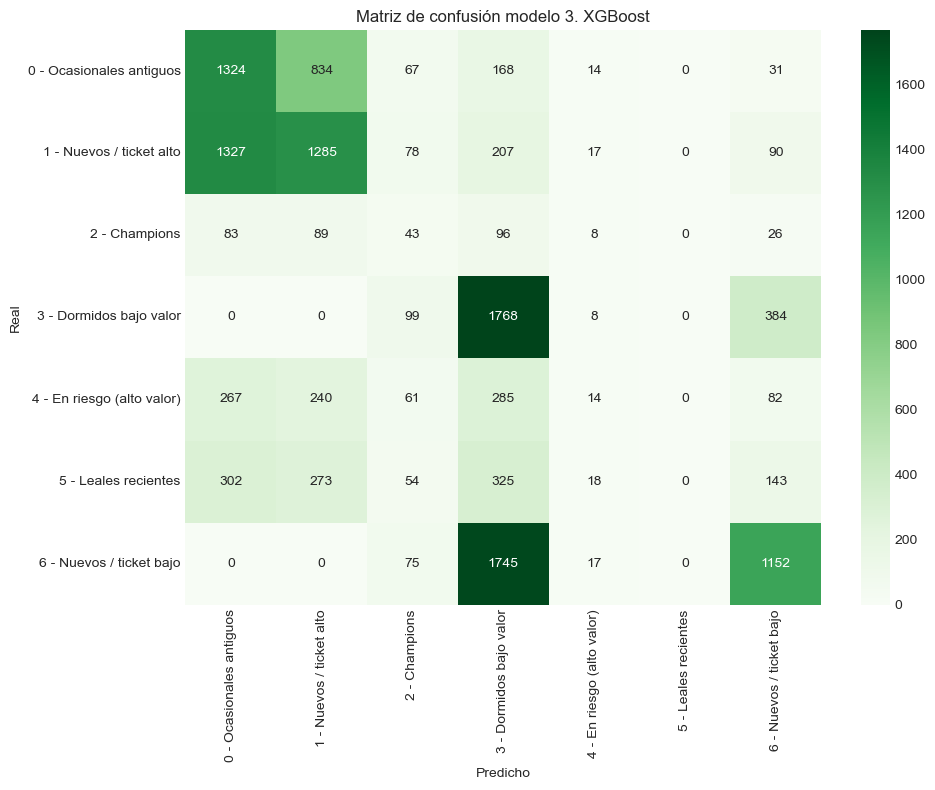

In [194]:
# ======================================
# Matriz de confusión
# ======================================

# Nombres de los clusters
client_model["cluster_id"] = client_model["cluster_id"].astype(int)
client_model["cluster_name"] = client_model["cluster_name"].astype(str)

id_to_name = (
    client_model[["cluster_id", "cluster_name"]]
    .drop_duplicates()
    .sort_values("cluster_id")
    .set_index("cluster_id")["cluster_name"]
    .to_dict()
)

cluster_ids = sorted(id_to_name.keys())
labels_txt = [f"{cid} - {id_to_name[cid]}" for cid in cluster_ids]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_xgb, labels=cluster_ids)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Greens"
)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión modelo 3. XGBoost")
plt.tight_layout()
plt.show()


Top 15 variables más importantes (XGBoost):


,feature,importance
3,BU_first_Footwear Division,0.120
0,first_ticket,0.098
15,Categoria_first_SERVICIO,0.079
9,Categoria_first_FOOTBALL/SOCCER AN,0.074
23,first_disc_group_Sin descuento,0.074
24,first_disc_group_Solo envío gratis,0.050
28,Genero_first_NIÑOS (KIDS),0.047
19,first_disc_group_Descuento alto (≥36%),0.032
4,BU_first_Otro,0.032
26,Genero_first_JORDAN BRAND,0.031


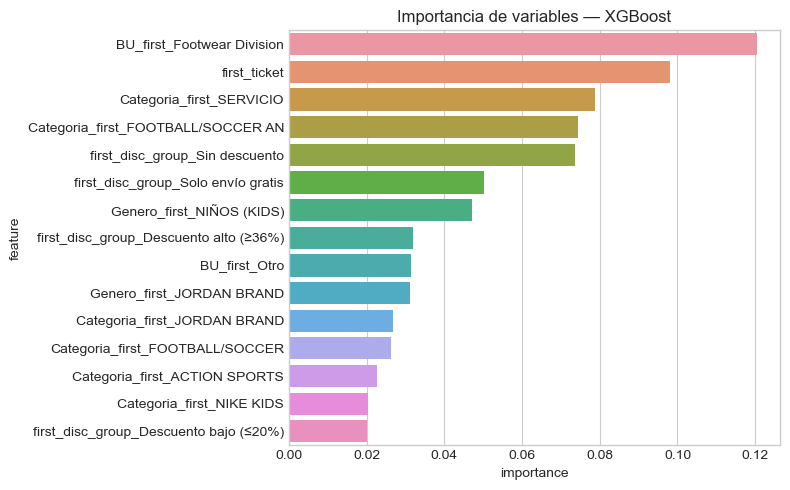

In [195]:
# ======================================
# Importancia de variables — XGBoost
# ======================================

fi_xgb = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_clf.feature_importances_
}).sort_values("importance", ascending=False)

fi_xgb = fi_xgb[fi_xgb["importance"] > 0]

print("Top 15 variables más importantes (XGBoost):")
display(fi_xgb.head(15))

plt.figure(figsize=(8,5))
sns.barplot(
    data=fi_xgb.head(15),
    x="importance",
    y="feature"
)
plt.title("Importancia de variables — XGBoost")
plt.tight_layout()
plt.show()


In [196]:
# ======================================
# 6. Comparación: Árbol vs MLP vs XGBoost
# ======================================

resumen_modelos = pd.DataFrame({
    "modelo": ["Árbol de decisión", "Red neuronal (MLP)", "XGBoost"],
    "accuracy": [acc_dt, acc_mlp, acc_xgb],
    "f1_macro": [f1_dt, f1_mlp, f1_xgb]
})

print("Comparación de desempeño (test):")
display(resumen_modelos)


Comparación de desempeño (test):


,modelo,accuracy,f1_macro
0,Árbol de decisión,0.430,0.293
1,Red neuronal (MLP),0.478,0.292
2,XGBoost,0.552,0.348


Los tres modelos evaluados presentan desempeños moderados, lo cual es habitual en problemas de clasificación temprana basados únicamente en la primera compra del cliente. Entre ellos, XGBoost alcanza las mejores métricas, por lo que se selecciona como el modelo base para aplicar Conformal Prediction.


# Conformal prediction

In [198]:
# ======================================
# Split interno: train - (train_model, calibration)
# ======================================
X_train_model, X_calib, y_train_model, y_calib = train_test_split(
    X_train, y_train,
    test_size=0.20,          # 20% calibración es estándar
    random_state=42,
    stratify=y_train
)

X_train_model.shape, X_calib.shape


((24451, 31), (6113, 31))

In [199]:
# ======================================
# Reentrenar XGBoost con subtraining (train_model)
# ======================================
num_classes = y.nunique()

xgb_cp = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

xgb_cp.fit(X_train_model, y_train_model)

print("XGBoost reentrenado para Conformal Prediction")


XGBoost reentrenado para Conformal Prediction


In [200]:
# ======================================
# Nonconformity scores en calibration set
# ======================================

# Probabilidades predichas en calibración
probs_calib = xgb_cp.predict_proba(X_calib)

# Nonconformity: 1 - prob(real_class)
alpha_scores = 1 - probs_calib[np.arange(len(y_calib)), y_calib.values]

alpha_scores[:10]  # vista rápida


array([0.32485235, 0.74787414, 0.33623397, 0.45002687, 0.6485274 ,
       0.8480189 , 0.8704831 , 0.5109736 , 0.72686714, 0.406478  ],
      dtype=float32)

In [201]:
# ======================================
# Función generadora de prediction sets
# ======================================
def conformal_prediction_set(probs, alpha_scores, alpha=0.10):
    """
    probs: vector de probabilidades predichas (1 x num_classes)
    alpha_scores: nonconformity calibrados
    alpha: nivel de error deseado (ej. 0.10 = 90% confianza)
    """
    # Umbral conformal
    q_hat = np.quantile(alpha_scores, 1 - alpha, interpolation="higher")
    
    prediction_set = []
    for c in range(len(probs)):
        nonconf = 1 - probs[c]
        if nonconf <= q_hat:
            prediction_set.append(c)
    return prediction_set, q_hat


In [219]:
# ======================================
# Aplicar Conformal Prediction al test set
# ======================================
probs_test = xgb_cp.predict_proba(X_test)

alpha = 0.10  # 90% confianza (puedes usar 0.05 para 95%)

prediction_sets = []
set_sizes = []

for i in range(len(X_test)):
    ps, q_hat = conformal_prediction_set(
        probs_test[i],
        alpha_scores,
        alpha=alpha
    )
    prediction_sets.append(ps)
    set_sizes.append(len(ps))

print("q_hat (umbral conformal):", q_hat)
print("Tamaño promedio prediction set:", np.mean(set_sizes))
print("Porcentaje de sets con tamaño 1:", np.mean(np.array(set_sizes)==1))
print("Porcentaje de sets con tamaño >1:", np.mean(np.array(set_sizes)>1))


/var/folders/d_/2pvct71j5rz3fqp48s3m8zt40000gn/T/ipykernel_85646/2974756213.py:11: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  q_hat = np.quantile(alpha_scores, 1 - alpha, interpolation="higher")


q_hat (umbral conformal): 0.92643005
Tamaño promedio prediction set: 3.274372089472479
Porcentaje de sets con tamaño 1: 0.030689365600427513
Porcentaje de sets con tamaño >1: 0.9693106343995724


In [220]:
# ======================================
# Validación: ¿el cluster real está dentro del prediction set?
# ======================================
y_test_arr = y_test.values

coverage = np.mean([
    y_test_arr[i] in prediction_sets[i]
    for i in range(len(y_test_arr))
])

print(f"Cobertura real obtenida: {coverage:.3f} (esperada ≥ {1-alpha})")


Cobertura real obtenida: 0.906 (esperada ≥ 0.9)


In [221]:
# ======================================
# DataFrame final de resultados
# ======================================
df_conformal = pd.DataFrame({
    "real_cluster": y_test_arr,
    "prediction": xgb_cp.predict(X_test),
    "prediction_set": prediction_sets,
    "set_size": set_sizes
})

df_conformal.head(10)


,real_cluster,prediction,prediction_set,set_size
0,0,0,"[0, 1, 2, 3, 4, 5]",6
1,1,1,"[0, 1, 5]",3
2,5,1,"[0, 1, 5]",3
3,1,6,"[1, 3, 5, 6]",4
4,1,1,"[0, 1, 4, 5]",4
5,2,1,"[0, 1, 3, 4, 5, 6]",6
6,6,6,"[1, 3, 5, 6]",4
7,4,1,"[0, 1, 4, 5]",4
8,3,3,"[3, 4, 5, 6]",4
9,3,3,"[3, 5, 6]",3


In [222]:
df_conformal.set_size.value_counts()

set_size
3    4461
4    3996
2    2987
5     575
6     473
1     402
7     205
Name: count, dtype: int64

In [235]:
df_conformal[df_conformal['set_size']==4].prediction_set.value_counts()

prediction_set
[0, 1, 4, 5]    2801
[3, 4, 5, 6]     437
[1, 3, 5, 6]     400
[0, 3, 5, 6]     101
[0, 3, 4, 6]      67
[0, 1, 3, 6]      61
[0, 1, 2, 4]      45
[1, 3, 4, 6]      35
[0, 1, 2, 5]      16
[1, 3, 4, 5]      11
[2, 3, 4, 6]       6
[0, 1, 3, 5]       5
[2, 3, 5, 6]       5
[0, 1, 3, 4]       2
[0, 2, 4, 5]       2
[0, 2, 3, 6]       2
Name: count, dtype: int64

    2: "Champions",
    5: "Leales recientes",
    4: "En riesgo (alto valor)",
    0: "Ocasionales antiguos",
    1: "Nuevos / ticket alto",
    6: "Nuevos / ticket bajo",
    3: "Dormidos bajo valor",